**Master IASD 2025**

Deep Learning for Image Analisis

Practical Session: Oct 24-2025

You should submit the notebook with the answers be email before the deadline.

Deadline: Oct 31-2025

Santiago VELASCO-FORERO santiago.velasco@minesparis.psl.eu

An **autoencoder** is a type of artificial neural network used for unsupervised learning. Its primary goal is to learn a compressed, efficient representation (encoding) of input data, and then reconstruct the original data from this encoding. Autoencoders are widely used for tasks like dimensionality reduction, anomaly detection, image denoising, and feature extraction.

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.51MB/s]


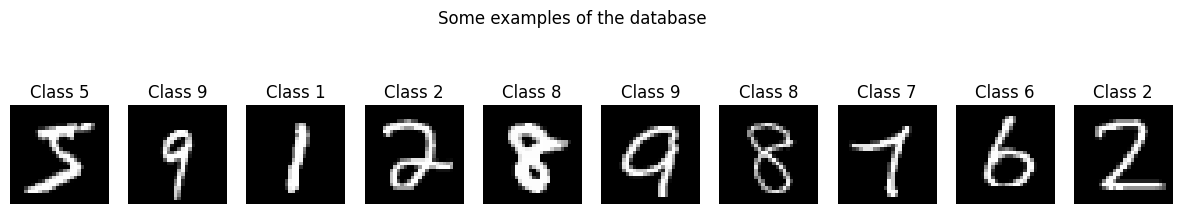

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 24
latent_dim = 2

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Plot one example per class
def plot_examples_per_class(dataset, num_classes=10):
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))
    for i in range(num_classes):
        img, label = dataset[i * 600]  # Pick one example per class
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Class {label}")
        axes[i].axis('off')
    plt.suptitle("Some examples of the database")
    plt.show()

plot_examples_per_class(train_dataset)





In [ ]:
# Function to add noise to MNIST images
def add_noise(img):
    noise = torch.randn(img.size()).to(device) * 0.2
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def forward_two(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded

# Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def forward_two(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded

# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc21 = nn.Linear(128, latent_dim)  # mu
        self.fc22 = nn.Linear(128, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def forward_two(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        #z = self.reparameterize(mu, logvar)
        return self.decode(mu), mu #, logvar


# Function to compute validation loss
def compute_val_loss(model, val_loader, criterion, is_vae=False):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            if is_vae:
                recon_batch, mu, logvar = model(img)
                val_loss += loss_function(recon_batch, img, mu, logvar).item()
            else:
                output = model(img)
                val_loss += criterion(output, img).item()
    return val_loss / len(val_loader.dataset)

# Function to train the autoencoder and save history
def train_autoencoder(model, train_loader, val_loader, num_epochs=num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)

            # Forward pass
            output = model(img)
            loss = criterion(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Compute validation loss
        val_loss = compute_val_loss(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Plot an example
        example_img = next(iter(val_loader))[0][0].to(device)
        plot_example(model, example_img, f"(Epoch {epoch+1})")

    return model, history

# Function to train the denoising autoencoder and save history
def train_denoising_autoencoder(model, train_loader, val_loader, num_epochs=num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img).to(device)  # Move noisy_img to the same device

            # Forward pass
            output = model(noisy_img)
            loss = criterion(output, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Compute validation loss
        val_loss = compute_val_loss(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Plot an example
        example_img = next(iter(val_loader))[0][0].to(device)
        plot_example(model, example_img, f"(Epoch {epoch+1})")
    return model, history



# Function to train the VAE and save history
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, train_loader, val_loader, num_epochs=num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)

            # Forward pass
            recon_batch, mu, logvar = model(img)
            loss = loss_function(recon_batch, img, mu, logvar)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Compute validation loss
        val_loss = compute_val_loss(model, val_loader, None, is_vae=True)
        history['val_loss'].append(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Plot an example
        example_img = next(iter(val_loader))[0][0].to(device)
        plot_example(model, example_img, f"(Epoch {epoch+1})", is_vae=True)

    return model, history

# Function to plot loss history
def plot_loss_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Function to plot input and output images
def plot_example(model, img, title, is_vae=False):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        if is_vae:
            recon_batch, _, _ = model(img)
            output = recon_batch
        else:
            output = model(img)
        img = img.squeeze().view(28, 28).cpu().numpy()
        output = output.squeeze().view(28, 28).cpu().numpy()

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.title(f"Input {title}")
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Output {title}")
        plt.imshow(output, cmap='gray')
        plt.axis('off')
        plt.show()

**Reparametrization trick**

Suppose $q_\phi(z)=N(\mu_{\phi},\sigma^2_{\phi}I)$.

The standard approach is to reparameterize $z$ as follows: $z=\mu_{\phi}+\sigma_{\phi}\odot\epsilon$, where $\epsilon \sim N(0,I)$. In this case, $\epsilon$ is independent of $\phi$.

The expectation becomes
$\mathbb{E}_{z \sim q_{\phi}(z)} (f(z))= \mathbb{E}_{\epsilon\sim N(0,I)}[f(\mu_{\phi}+\sigma_{\phi}\odot \epsilon)]$

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# Initialize models
autoencoder = Autoencoder(latent_dim).to(device)
denosing_autoencoder = DenoisingAutoencoder(latent_dim).to(device)
vae = VAE(latent_dim).to(device)


Training Autoencoder...
Epoch [1/24], Train Loss: 0.0017, Val Loss: 0.0015


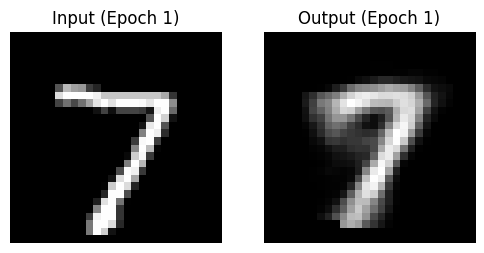

Epoch [2/24], Train Loss: 0.0015, Val Loss: 0.0014


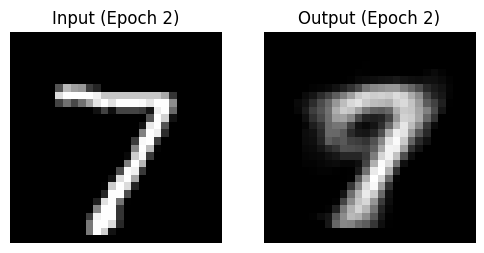

Epoch [3/24], Train Loss: 0.0014, Val Loss: 0.0014


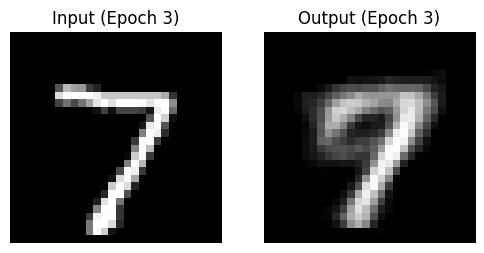

Epoch [4/24], Train Loss: 0.0014, Val Loss: 0.0014


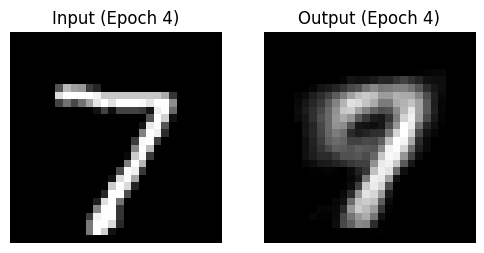

Epoch [5/24], Train Loss: 0.0014, Val Loss: 0.0014


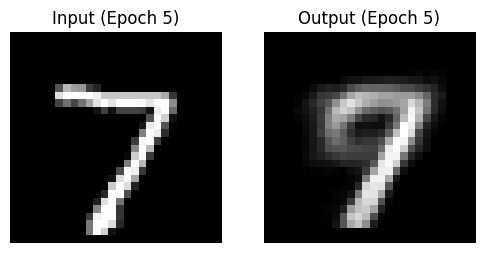

Epoch [6/24], Train Loss: 0.0013, Val Loss: 0.0013


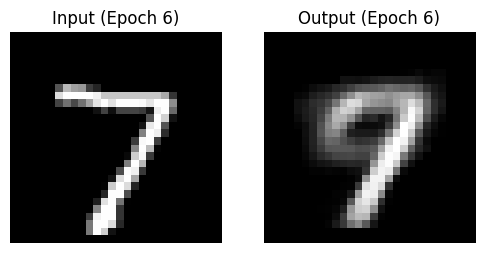

Epoch [7/24], Train Loss: 0.0013, Val Loss: 0.0013


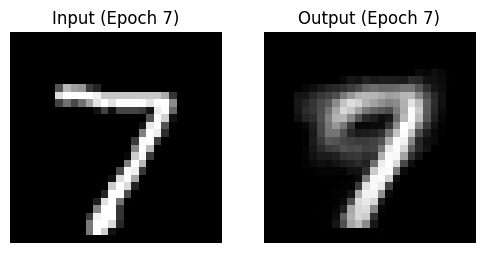

Epoch [8/24], Train Loss: 0.0013, Val Loss: 0.0013


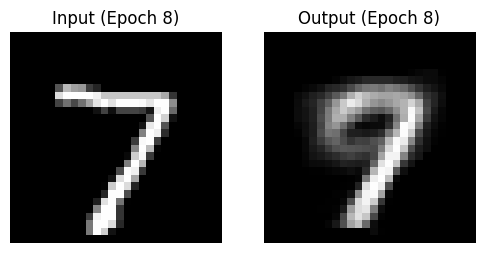

Epoch [9/24], Train Loss: 0.0013, Val Loss: 0.0013


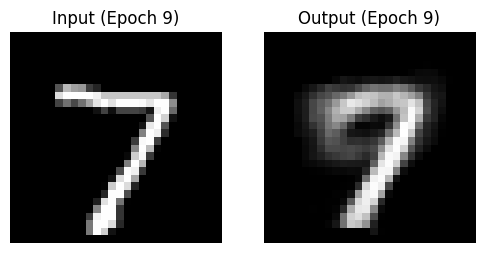

Epoch [10/24], Train Loss: 0.0013, Val Loss: 0.0013


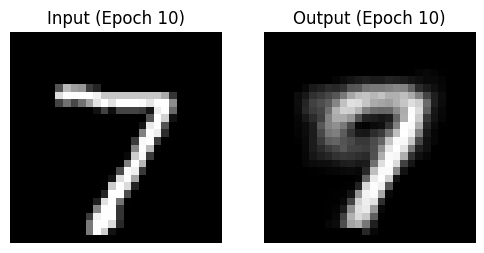

Epoch [11/24], Train Loss: 0.0013, Val Loss: 0.0013


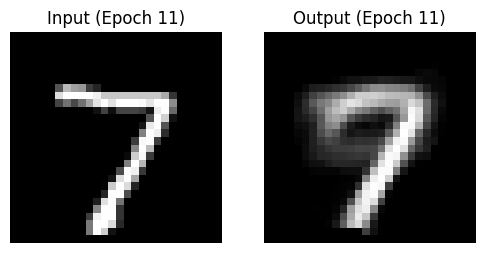

Epoch [12/24], Train Loss: 0.0013, Val Loss: 0.0013


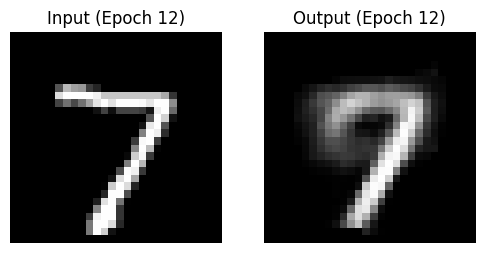

Epoch [13/24], Train Loss: 0.0013, Val Loss: 0.0013


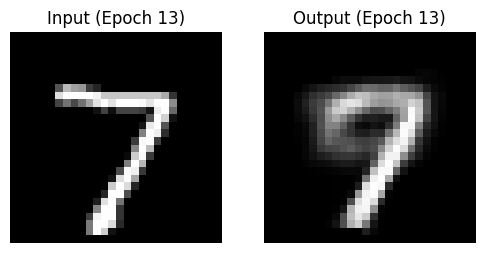

Epoch [14/24], Train Loss: 0.0013, Val Loss: 0.0013


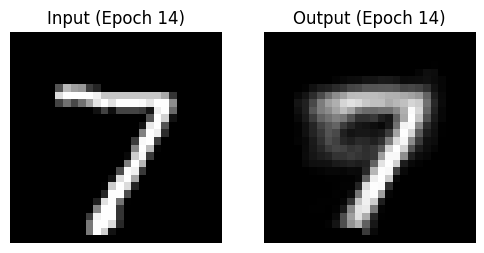

Epoch [15/24], Train Loss: 0.0013, Val Loss: 0.0013


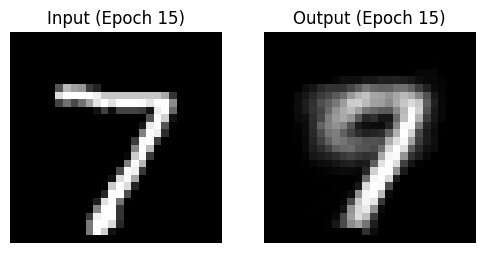

Epoch [16/24], Train Loss: 0.0013, Val Loss: 0.0013


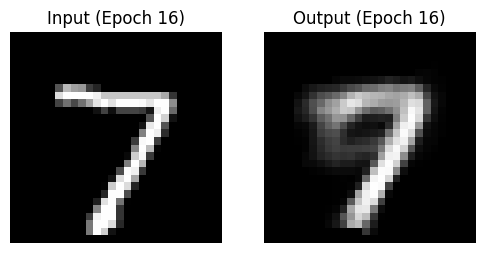

Epoch [17/24], Train Loss: 0.0013, Val Loss: 0.0013


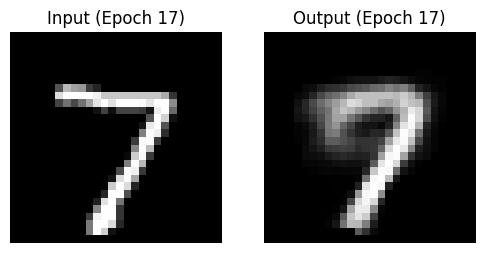

Epoch [18/24], Train Loss: 0.0013, Val Loss: 0.0013


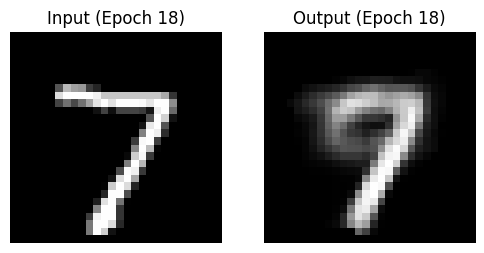

Epoch [19/24], Train Loss: 0.0012, Val Loss: 0.0013


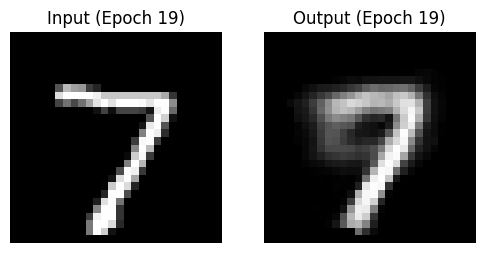

Epoch [20/24], Train Loss: 0.0012, Val Loss: 0.0013


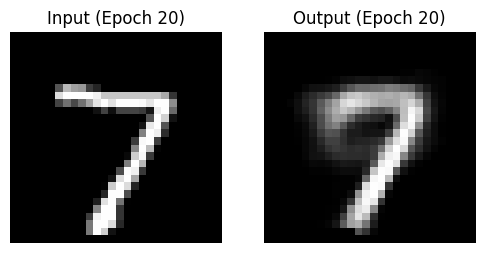

Epoch [21/24], Train Loss: 0.0012, Val Loss: 0.0013


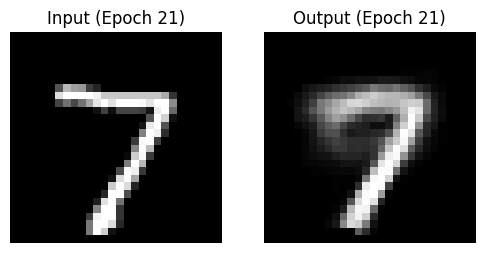

Epoch [22/24], Train Loss: 0.0012, Val Loss: 0.0013


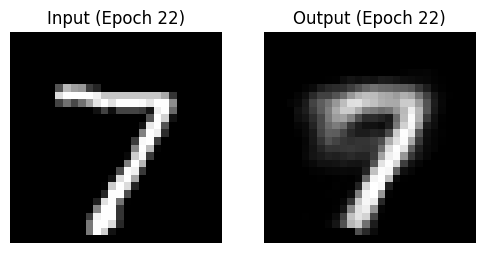

Epoch [23/24], Train Loss: 0.0012, Val Loss: 0.0013


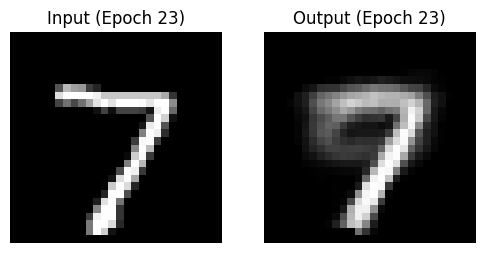

Epoch [24/24], Train Loss: 0.0012, Val Loss: 0.0013


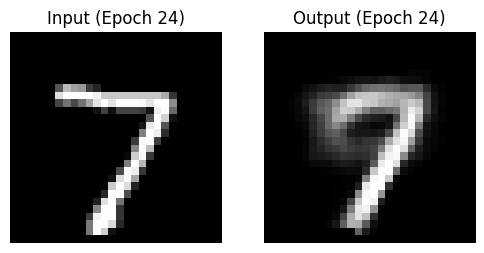

In [ ]:
# Train models and save history
print("Training Autoencoder...")
trained_autoencoder, ae_history = train_autoencoder(autoencoder, train_loader, val_loader)




Training Denoising Autoencoder...
Epoch [1/24], Train Loss: 0.0017, Val Loss: 0.0016


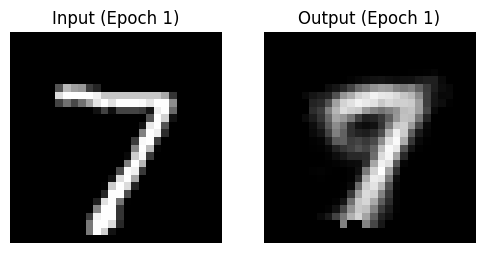

Epoch [2/24], Train Loss: 0.0015, Val Loss: 0.0015


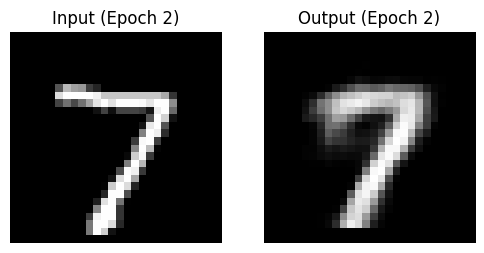

Epoch [3/24], Train Loss: 0.0014, Val Loss: 0.0015


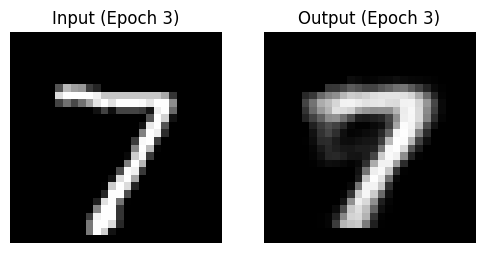

Epoch [4/24], Train Loss: 0.0014, Val Loss: 0.0015


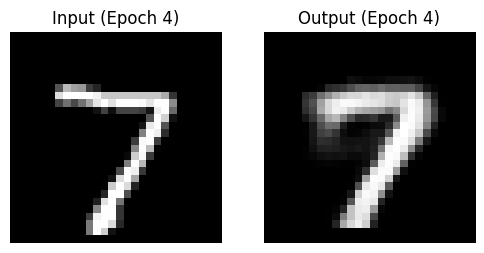

Epoch [5/24], Train Loss: 0.0014, Val Loss: 0.0015


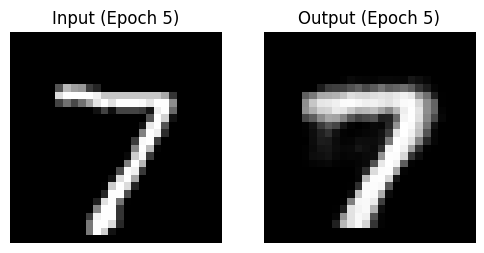

Epoch [6/24], Train Loss: 0.0013, Val Loss: 0.0014


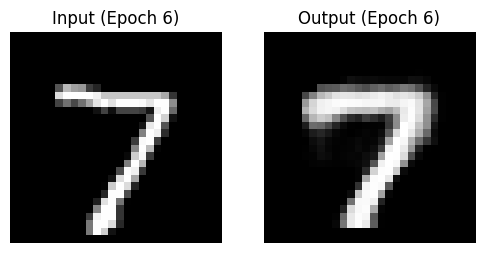

Epoch [7/24], Train Loss: 0.0013, Val Loss: 0.0014


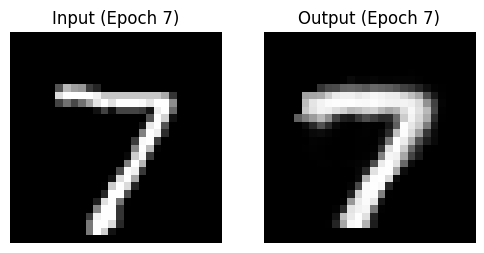

Epoch [8/24], Train Loss: 0.0013, Val Loss: 0.0014


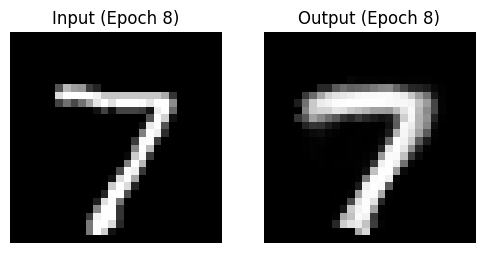

Epoch [9/24], Train Loss: 0.0013, Val Loss: 0.0014


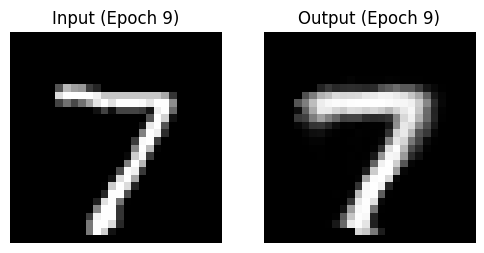

Epoch [10/24], Train Loss: 0.0013, Val Loss: 0.0014


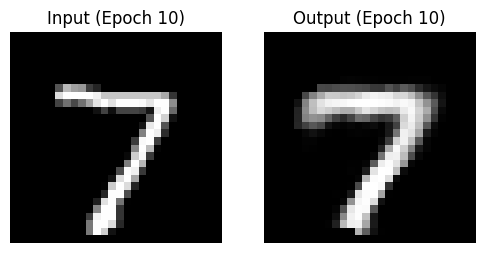

Epoch [11/24], Train Loss: 0.0013, Val Loss: 0.0014


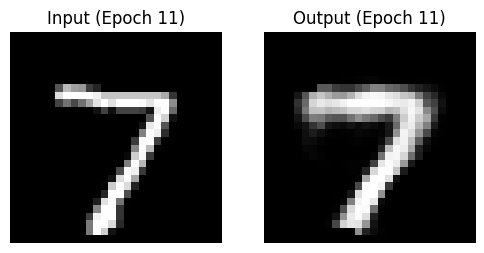

Epoch [12/24], Train Loss: 0.0013, Val Loss: 0.0014


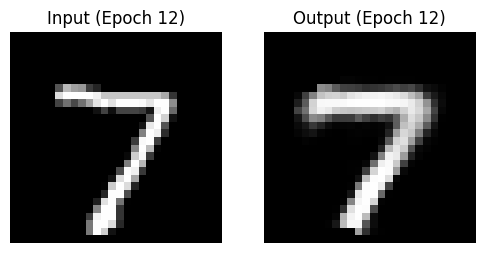

Epoch [13/24], Train Loss: 0.0013, Val Loss: 0.0014


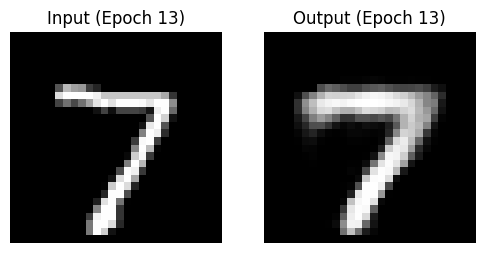

Epoch [14/24], Train Loss: 0.0013, Val Loss: 0.0014


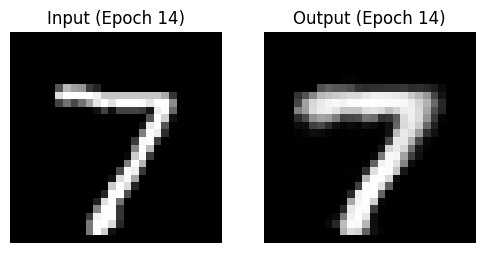

Epoch [15/24], Train Loss: 0.0013, Val Loss: 0.0014


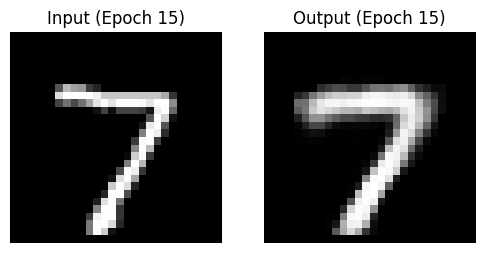

Epoch [16/24], Train Loss: 0.0013, Val Loss: 0.0014


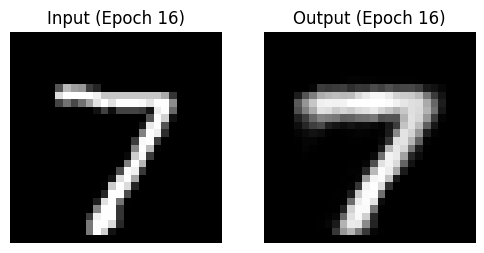

Epoch [17/24], Train Loss: 0.0013, Val Loss: 0.0014


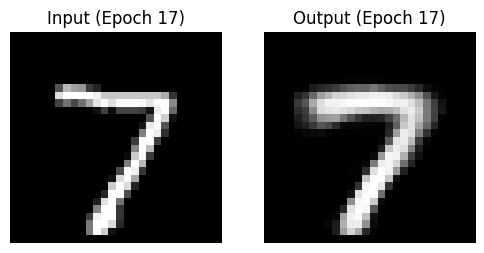

Epoch [18/24], Train Loss: 0.0013, Val Loss: 0.0014


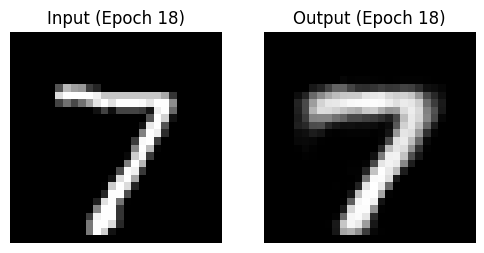

Epoch [19/24], Train Loss: 0.0013, Val Loss: 0.0014


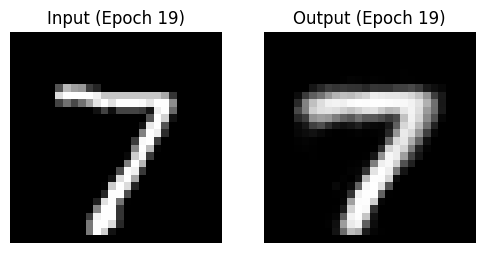

Epoch [20/24], Train Loss: 0.0013, Val Loss: 0.0014


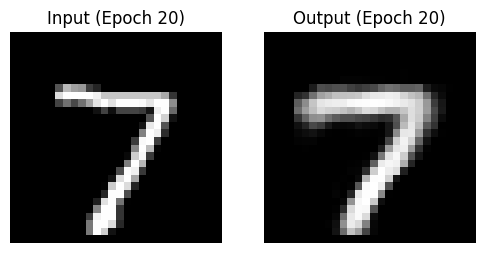

Epoch [21/24], Train Loss: 0.0013, Val Loss: 0.0014


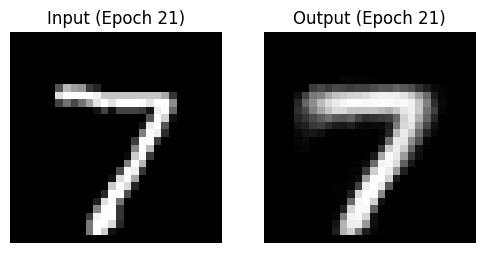

Epoch [22/24], Train Loss: 0.0013, Val Loss: 0.0014


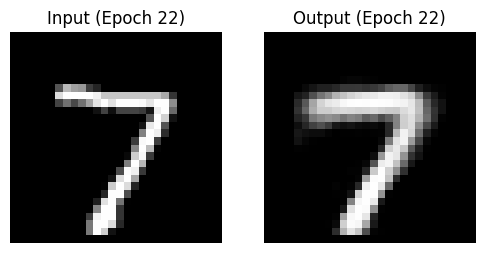

Epoch [23/24], Train Loss: 0.0013, Val Loss: 0.0014


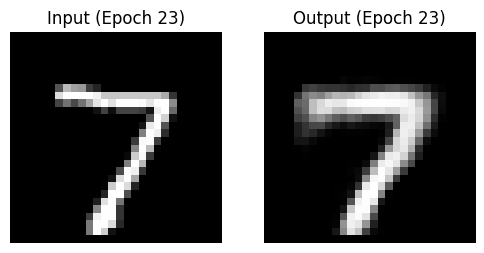

Epoch [24/24], Train Loss: 0.0013, Val Loss: 0.0014


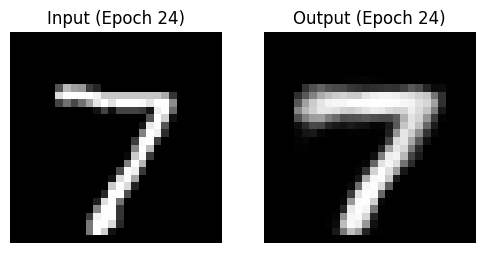

In [ ]:
print("\nTraining Denoising Autoencoder...")
trained_denoising_autoencoder, dae_history = train_denoising_autoencoder(denosing_autoencoder, train_loader, val_loader)



Training Variational Autoencoder...
Epoch [1/24], Train Loss: 183.2426, Val Loss: 168.4197


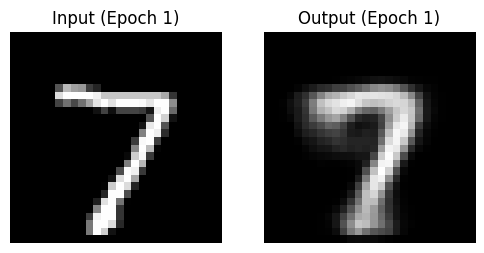

Epoch [2/24], Train Loss: 166.2094, Val Loss: 163.9474


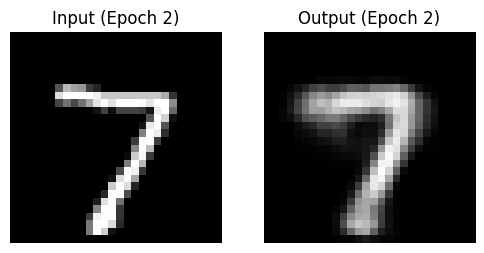

Epoch [3/24], Train Loss: 163.0850, Val Loss: 161.5689


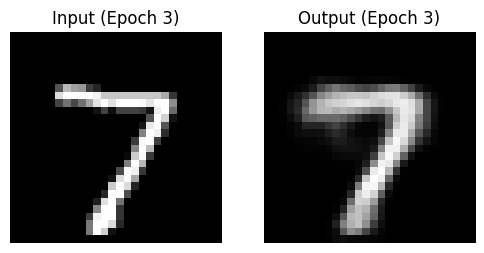

Epoch [4/24], Train Loss: 161.0702, Val Loss: 159.6339


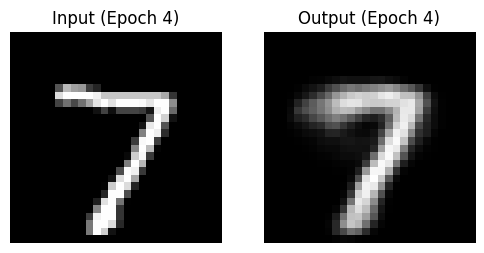

Epoch [5/24], Train Loss: 159.3328, Val Loss: 157.9795


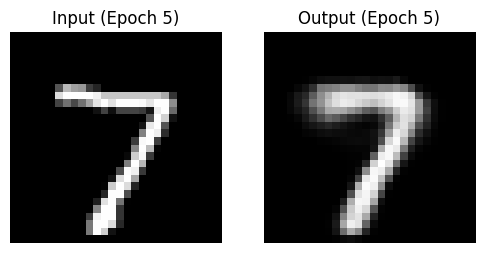

Epoch [6/24], Train Loss: 157.8073, Val Loss: 156.9753


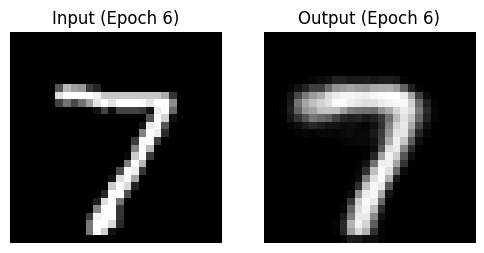

Epoch [7/24], Train Loss: 156.6059, Val Loss: 156.2171


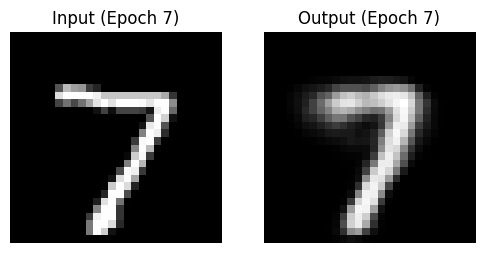

Epoch [8/24], Train Loss: 155.6628, Val Loss: 155.2262


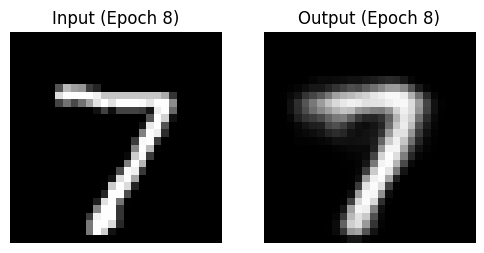

Epoch [9/24], Train Loss: 154.9701, Val Loss: 154.7076


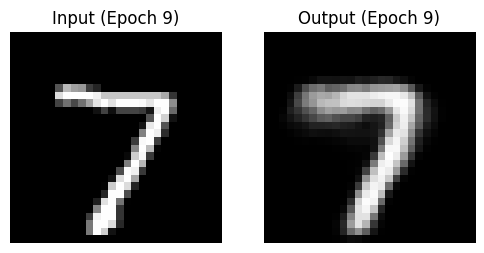

Epoch [10/24], Train Loss: 154.3884, Val Loss: 154.3468


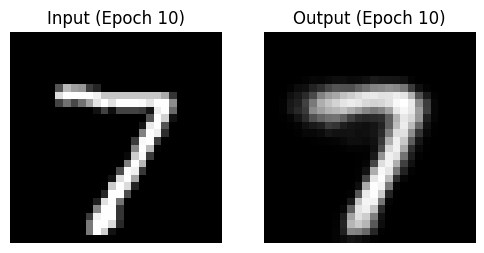

Epoch [11/24], Train Loss: 153.9044, Val Loss: 153.8482


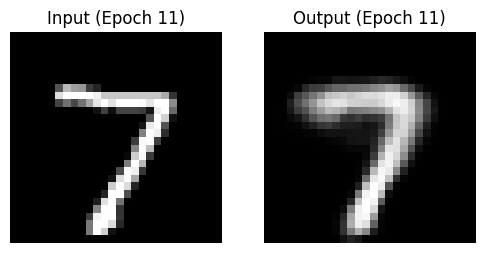

Epoch [12/24], Train Loss: 153.4581, Val Loss: 153.4352


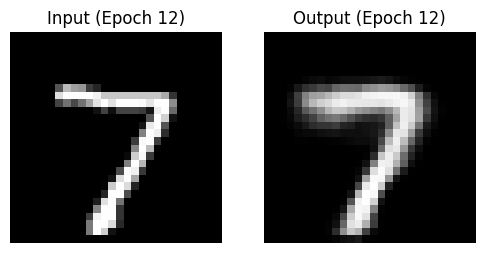

Epoch [13/24], Train Loss: 153.0865, Val Loss: 152.9203


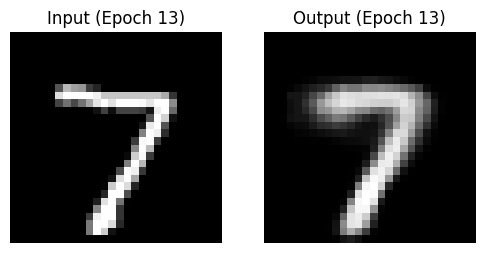

Epoch [14/24], Train Loss: 152.7691, Val Loss: 152.9784


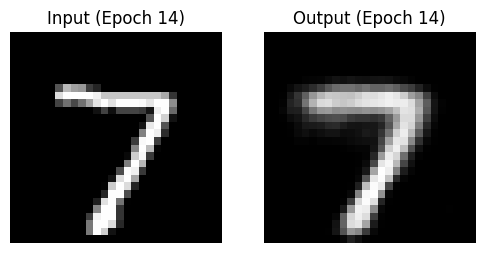

Epoch [15/24], Train Loss: 152.4334, Val Loss: 152.9255


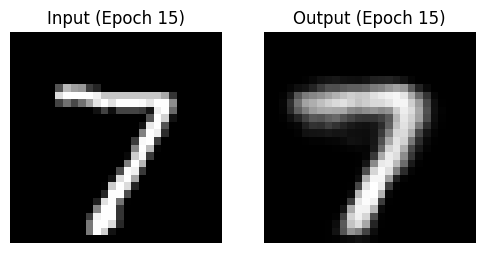

Epoch [16/24], Train Loss: 152.1906, Val Loss: 152.7107


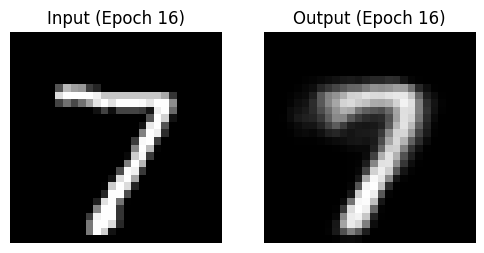

Epoch [17/24], Train Loss: 151.9681, Val Loss: 152.2192


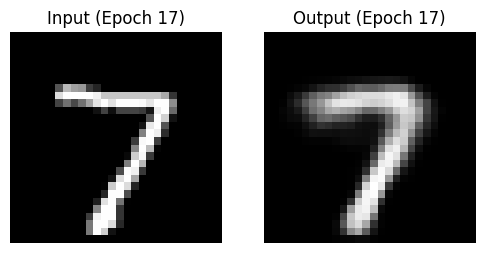

Epoch [18/24], Train Loss: 151.6951, Val Loss: 152.8084


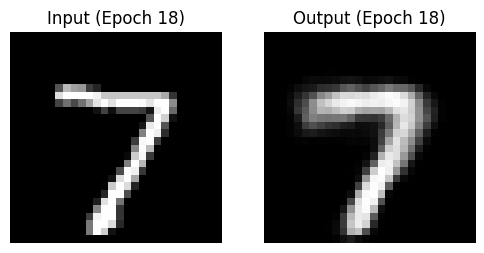

Epoch [19/24], Train Loss: 151.4675, Val Loss: 152.1374


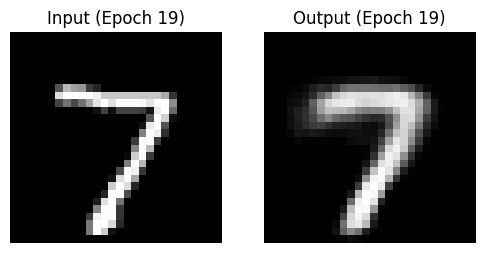

Epoch [20/24], Train Loss: 151.2634, Val Loss: 151.6695


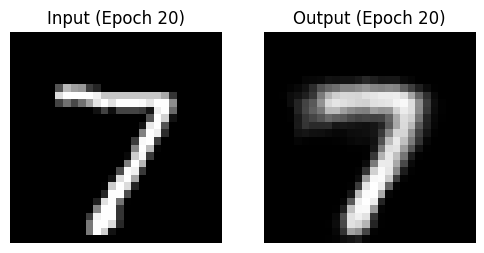

Epoch [21/24], Train Loss: 151.0573, Val Loss: 151.5136


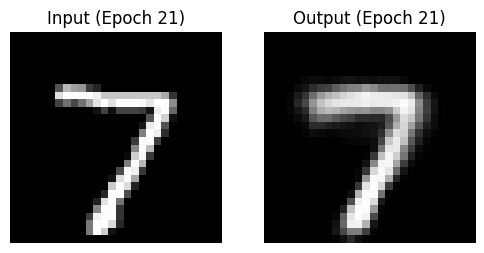

Epoch [22/24], Train Loss: 150.8764, Val Loss: 151.7964


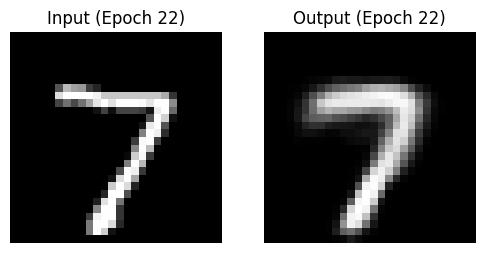

Epoch [23/24], Train Loss: 150.6725, Val Loss: 151.5840


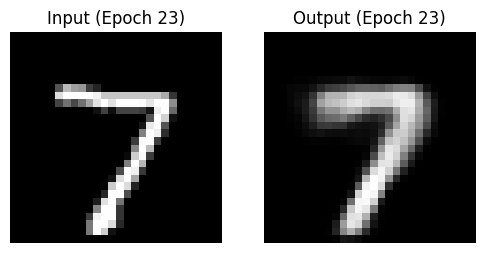

Epoch [24/24], Train Loss: 150.4901, Val Loss: 151.6423


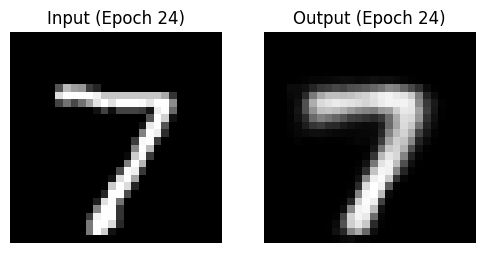

In [ ]:

print("\nTraining Variational Autoencoder...")
trained_vae, vae_history = train_vae(vae, train_loader, val_loader)


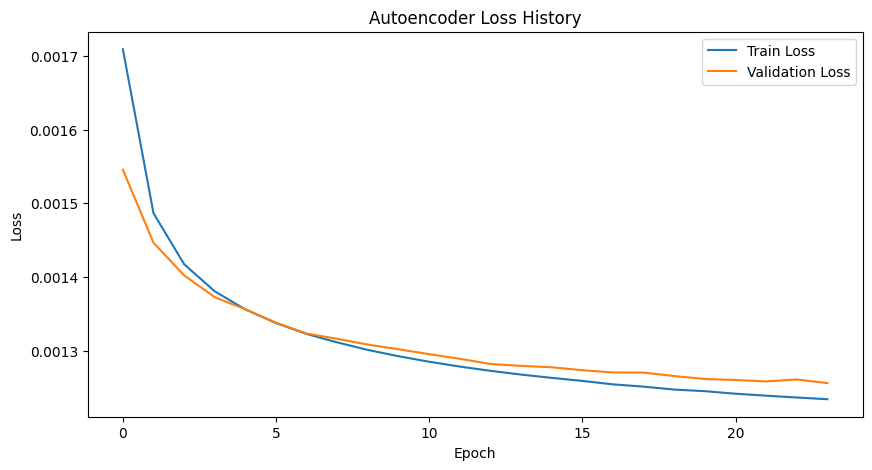

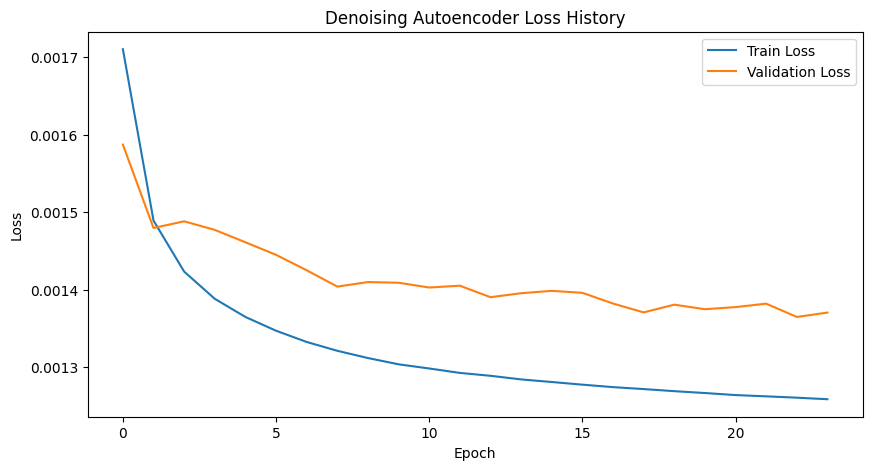

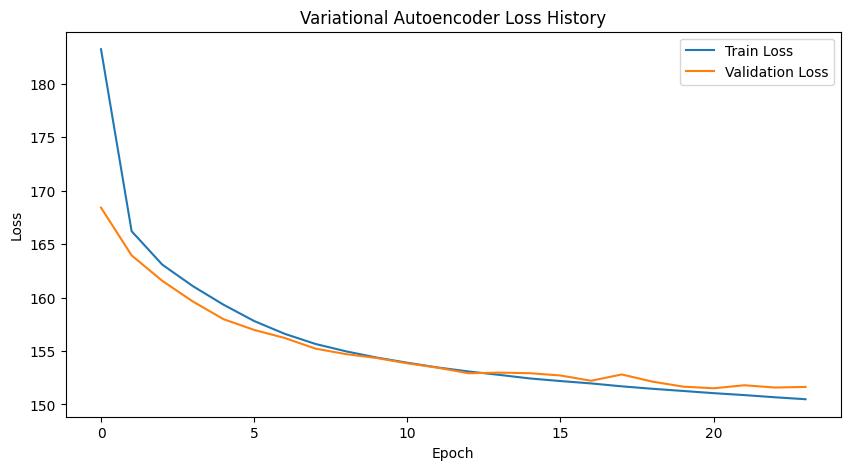

In [ ]:

# Plot loss history
plot_loss_history(ae_history, 'Autoencoder Loss History')
plot_loss_history(dae_history, 'Denoising Autoencoder Loss History')
plot_loss_history(vae_history, 'Variational Autoencoder Loss History')



In [ ]:
def extract_latent_representations(model, data_loader):
    model.eval()
    latent_reps = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            img, label = data
            img = img.to(device)
            img = img.view(img.size(0), -1)  # Flatten
            output = model.forward_two(img)
            #print("Model output type:", type(output), "length:", len(output))  # Debugging line
            decoded, encoded = output
            latent_reps.append(encoded.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(latent_reps), np.concatenate(labels)



In [ ]:
latent_reps, labels = extract_latent_representations(trained_autoencoder, train_loader)

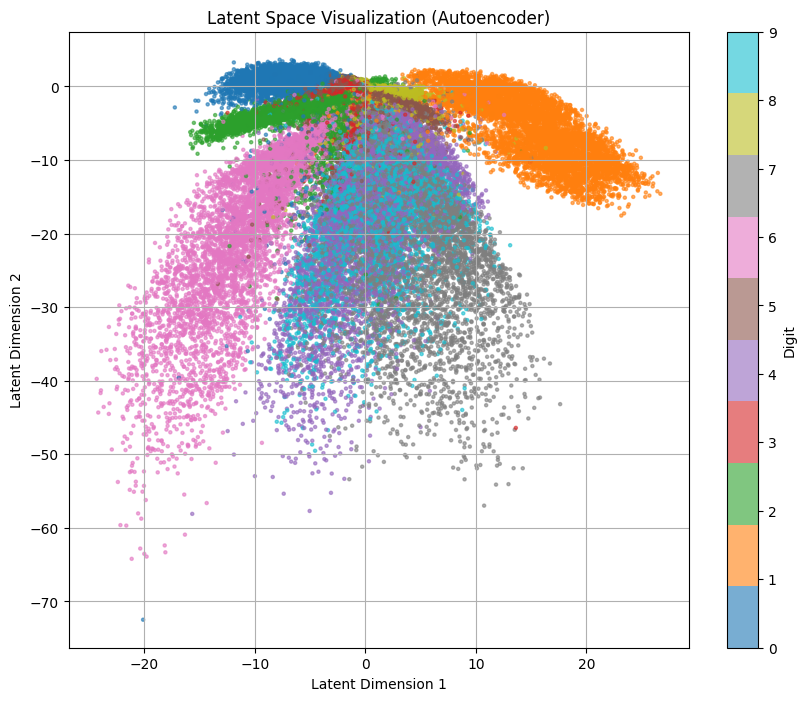

In [ ]:
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('Latent Space Visualization (Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

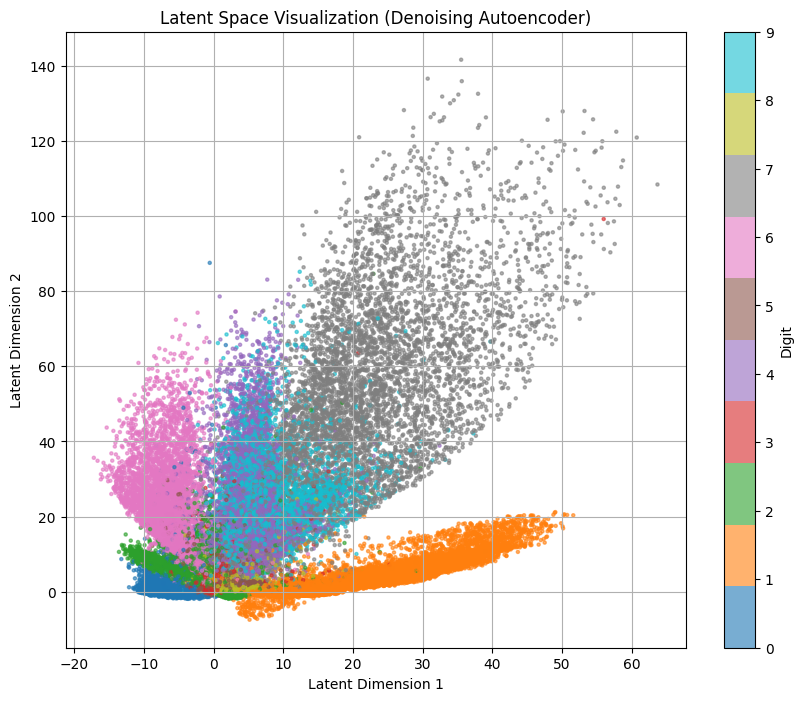

In [ ]:
latent_reps, labels = extract_latent_representations(trained_denoising_autoencoder, train_loader)
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('Latent Space Visualization (Denoising Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

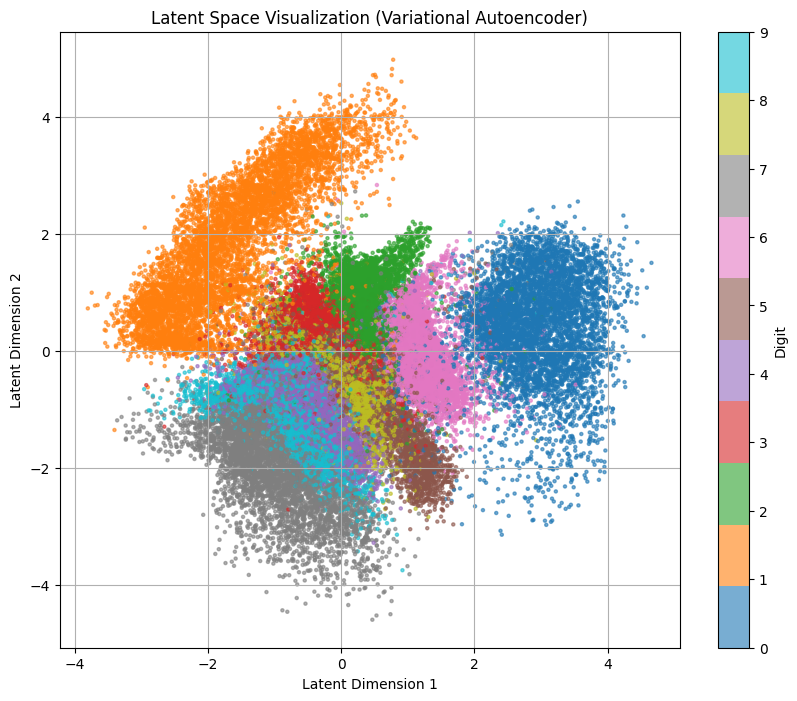

In [ ]:
latent_reps, labels = extract_latent_representations(trained_vae, train_loader)
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('Latent Space Visualization (Variational Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

In [ ]:
# Function to plot interpolation in latent space
def plot_latent_interpolation(model, n=12, digit_size=28):
    model.eval()
    plt.figure(figsize=(18, 4))

    # Generate latent vectors on the same device as the model
    z1 = torch.randn(1, latent_dim, device=device)
    z2 = torch.randn(1, latent_dim, device=device)

    # Interpolation
    z = torch.stack([z1 + (z2 - z1) * t for t in np.linspace(0, 1, n)])
    z = z.squeeze(0)  # Shape: [n, latent_dim]

    # Decode
    with torch.no_grad():
        if hasattr(model, 'decoder'):
            samples = torch.sigmoid(model.decoder(z)).cpu()
        else:
            # For VAE, use the decode method
            samples = torch.sigmoid(model.decode(z)).cpu()
        samples = samples.view(n, digit_size, digit_size)

    # Plot
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(samples[i].numpy(), cmap='gray')
        plt.axis('off')

    plt.show()


Autoencoder Interpolation:


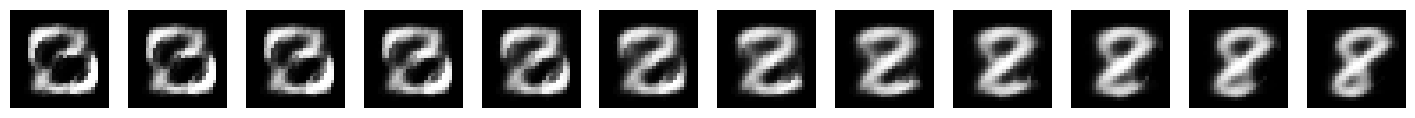


Denoising Autoencoder Interpolation:


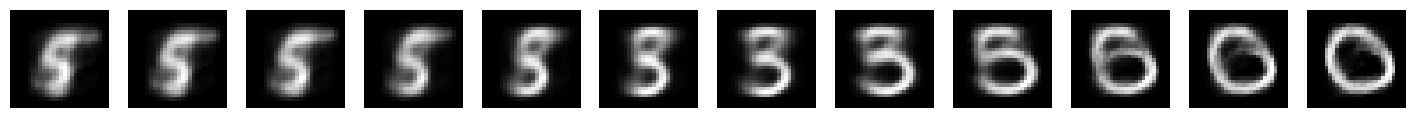


Variational Autoencoder Interpolation:


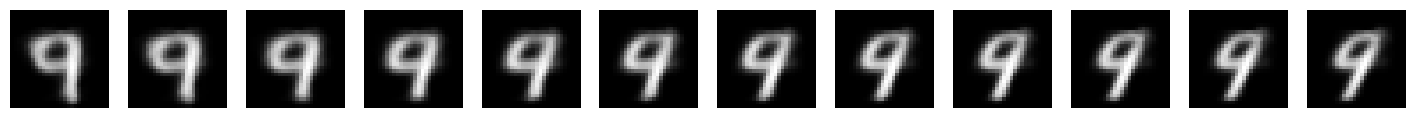

In [ ]:
# Plot interpolation for each model for two random points
print("\nAutoencoder Interpolation:")
plot_latent_interpolation(trained_autoencoder)

print("\nDenoising Autoencoder Interpolation:")
plot_latent_interpolation(trained_denoising_autoencoder)

print("\nVariational Autoencoder Interpolation:")
plot_latent_interpolation(trained_vae)

Q1. Create a function to visualize la decoder of the interpolated points in the latent between (0,0) and (1,1), and compare the result of the three models.

In [ ]:
# Function to plot interpolation in latent space
def plot_latent_interpolation_from_coordinates(model, z1, z2, n=12, digit_size=28):
    model.eval()
    # z1 and z2 are coordinates in the latent space
    plt.figure(figsize=(18, 4))

    # Create interpolation latent vectors between z1 and z2
    z = torch.stack([z1 + (z2 - z1) * t for t in torch.linspace(0, 1, n)]).squeeze(1)

    # Decode each latent vector
    with torch.no_grad():
        if hasattr(model, 'decoder'):
            # For Autoencoder and Denoising Autoencoder
            samples = torch.sigmoid(model.decoder(z.to(device))).cpu()
        else:
            # For Variational Autoencoder
            samples = torch.sigmoid(model.decode(z.to(device))).cpu()

    samples = samples.view(n, digit_size, digit_size)

    # Plot
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(samples[i].numpy(), cmap='gray')
        plt.axis('off')

    plt.show()




Autoencoder Interpolation:


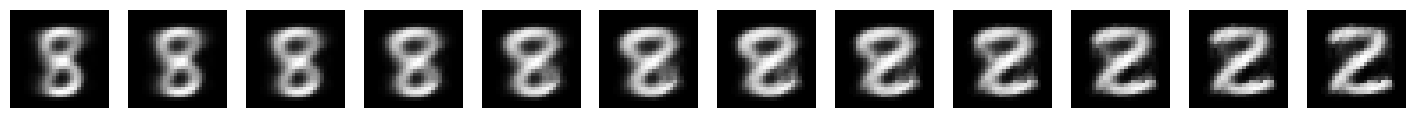


Denoising Autoencoder Interpolation:


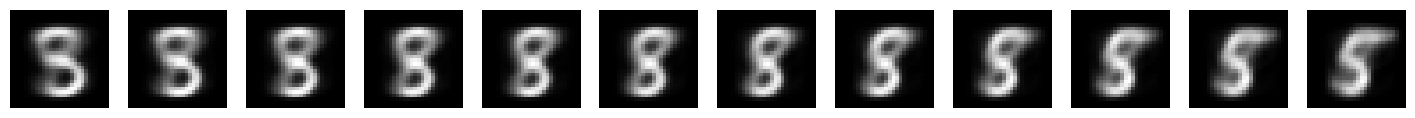


Variational Autoencoder Interpolation:


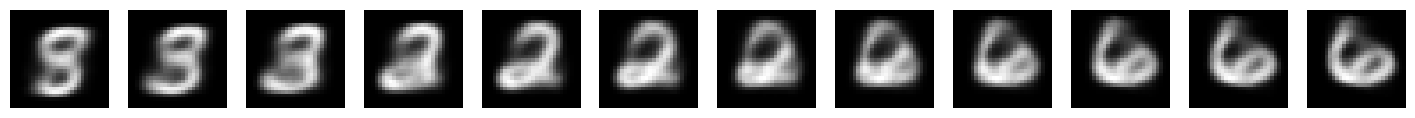

In [ ]:
print("\nAutoencoder Interpolation:")
plot_latent_interpolation_from_coordinates(trained_autoencoder,torch.zeros(1,2,device=device),torch.ones(1,2,device=device))

print("\nDenoising Autoencoder Interpolation:")
plot_latent_interpolation_from_coordinates(trained_denoising_autoencoder,torch.zeros(1,2,device=device),torch.ones(1,2,device=device))


print("\nVariational Autoencoder Interpolation:")
plot_latent_interpolation_from_coordinates(trained_vae,torch.zeros(1,2,device=device),torch.ones(1,2,device=device))


Q2. Create a function to visualize la interpolatation between to given images and compare the result of the three models.

In [ ]:
def plot_interpolation_between_images(model, img1, img2, n=24, digit_size=28):
    model.eval()
    with torch.no_grad():
        # Flatten images and send to device
        img1_flat = img1.view(1, -1).to(device)
        img2_flat = img2.view(1, -1).to(device)

        # Encode the two images to latent space
        if isinstance(model, VAE):
            mu1, logvar1 = model.encode(img1_flat)
            mu2, logvar2 = model.encode(img2_flat)
            z1 = model.reparameterize(mu1, logvar1)
            z2 = model.reparameterize(mu2, logvar2)
        else:
            z1 = model.encoder(img1_flat)
            z2 = model.encoder(img2_flat)

        # Interpolate linearly in latent space
        interpolations = torch.stack([z1 + (z2 - z1) * t for t in torch.linspace(0, 1, n)], dim=0)

        # Decode interpolated points to images
        if hasattr(model, 'decoder'):
            decoded = torch.sigmoid(model.decoder(interpolations)).cpu()
        else:
            decoded = torch.sigmoid(model.decode(interpolations)).cpu()  # For VAE

        # Plot the images
        plt.figure(figsize=(18, 4))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(decoded[i].view(digit_size, digit_size).numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

In [ ]:
# Example usage
img1 = train_dataset[1][0]  # First image
img2 = train_dataset[3][0]  # Second image


Interpolation between two given images:


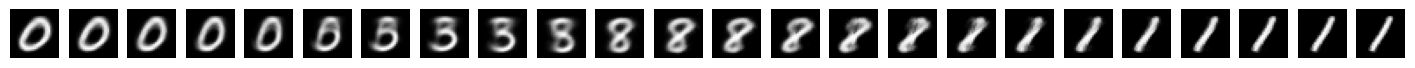

In [ ]:
print("Interpolation between two given images:")
plot_interpolation_between_images(trained_autoencoder, img1, img2)

Interpolation between two given images:


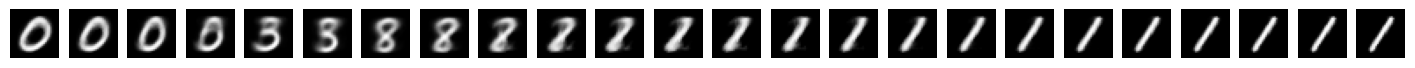

In [ ]:
print("Interpolation between two given images:")
plot_interpolation_between_images(trained_denoising_autoencoder, img1, img2)


Interpolation between two given images:


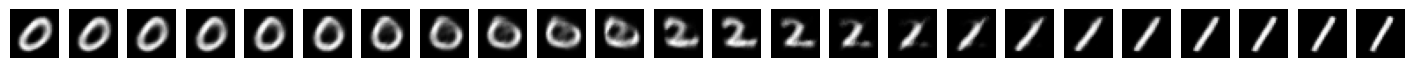

In [ ]:
print("Interpolation between two given images:")
plot_interpolation_between_images(trained_vae, img1, img2)

In [ ]:
def plot_latent_space_grid(model, n=10, digit_size=28, x_range=(-3, 3), y_range=(-3, 3)):
    model.eval()
    plt.figure(figsize=(15, 15))

    # Create a grid of latent vectors
    x = np.linspace(x_range[0], x_range[1], n)
    y = np.linspace(y_range[0], y_range[1], n)
    z = np.empty((n, n, latent_dim))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            z[i, j, 0] = xi
            z[i, j, 1] = yj

    # Decode each point in the grid
    with torch.no_grad():
        z_tensor = torch.FloatTensor(z).view(-1, latent_dim).to(device)
        if hasattr(model, 'decoder'):
            samples = torch.sigmoid(model.decoder(z_tensor)).cpu()
        else:
            # For VAE, use the decode method
            samples = torch.sigmoid(model.decode(z_tensor)).cpu()
        samples = samples.view(n, n, digit_size, digit_size)

    # Plot the grid
    for i in range(n):
        for j in range(n):
            plt.subplot(n, n, i * n + j + 1)
            plt.imshow(samples[i, j].numpy(), cmap='gray')
            plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

2D Latent Space Grid:


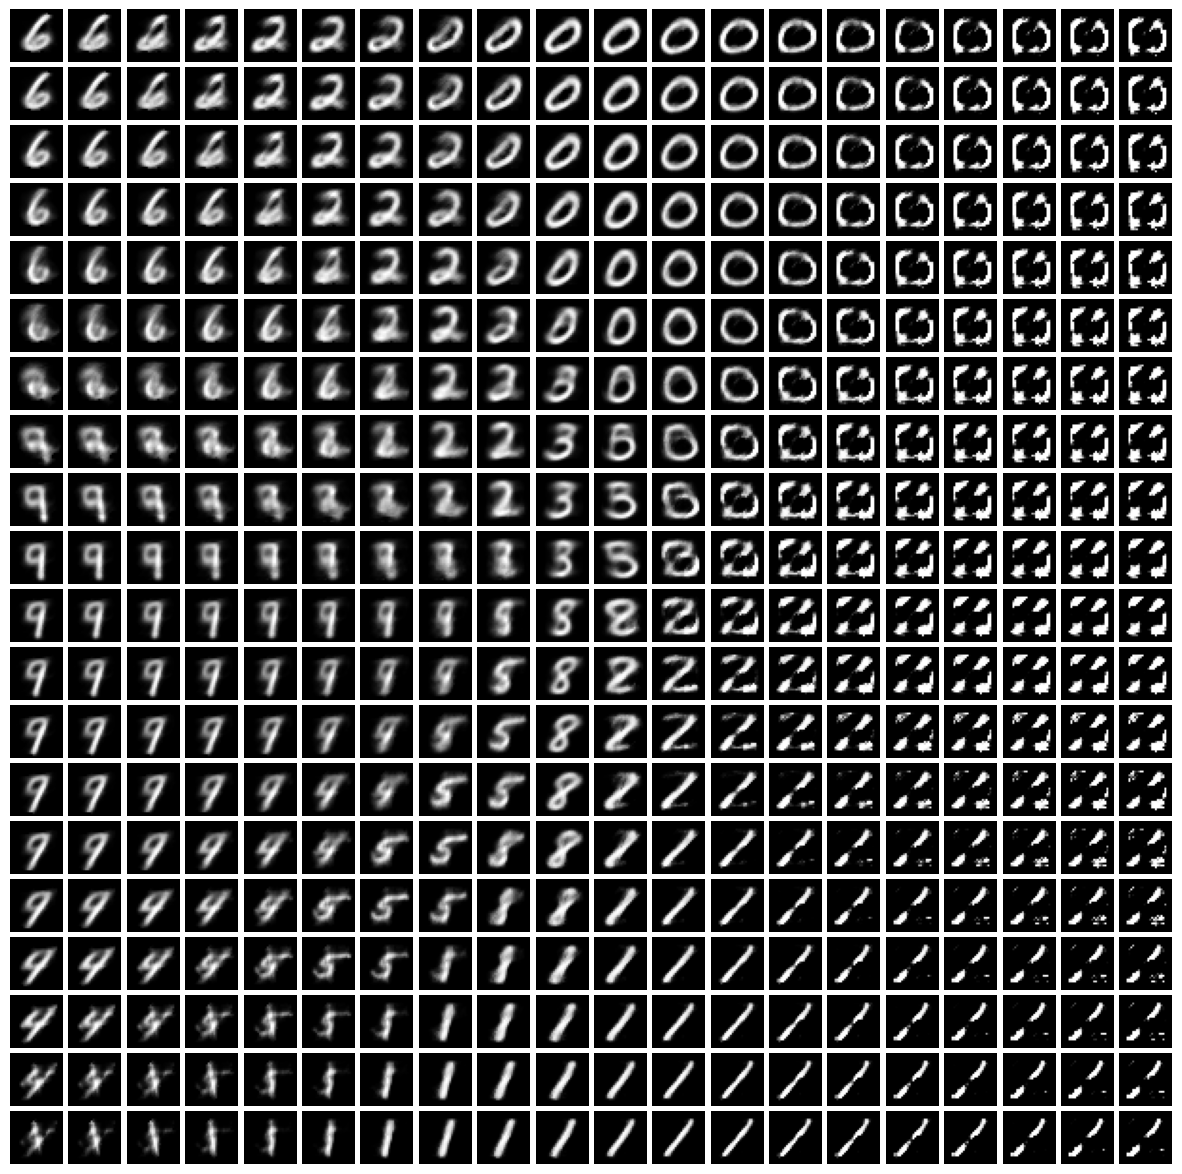

In [ ]:
print("2D Latent Space Grid:")
plot_latent_space_grid(trained_autoencoder, n=20, x_range=(-10, 10), y_range=(-10, 10))

2D Latent Space Grid:


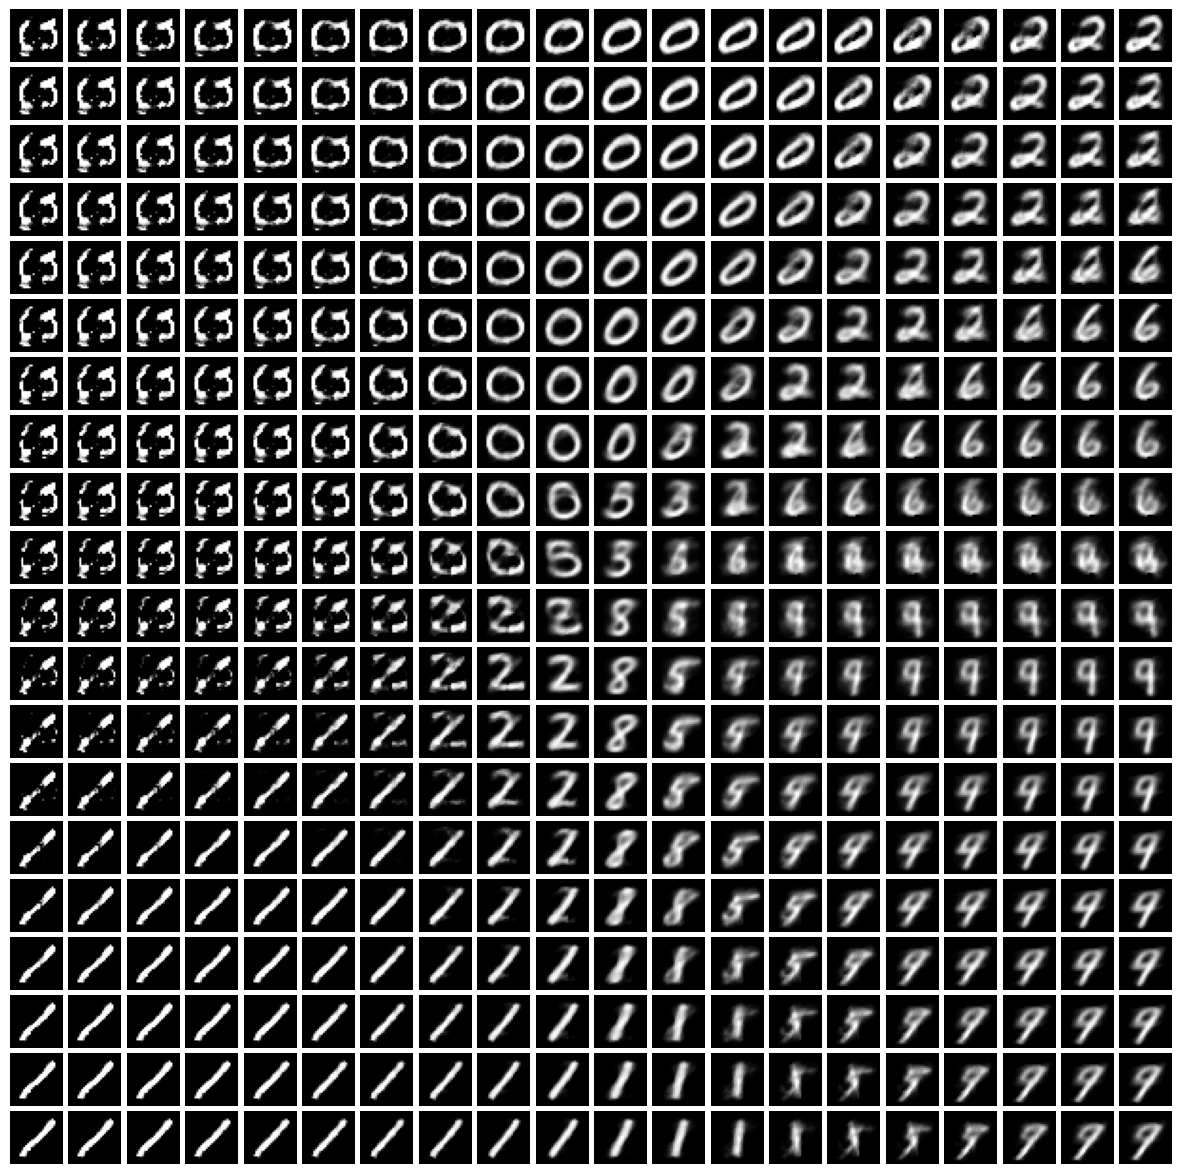

In [ ]:
print("2D Latent Space Grid:")
plot_latent_space_grid(trained_denoising_autoencoder, n=20, x_range=(-10, 10), y_range=(-10, 10))

2D Latent Space Grid:


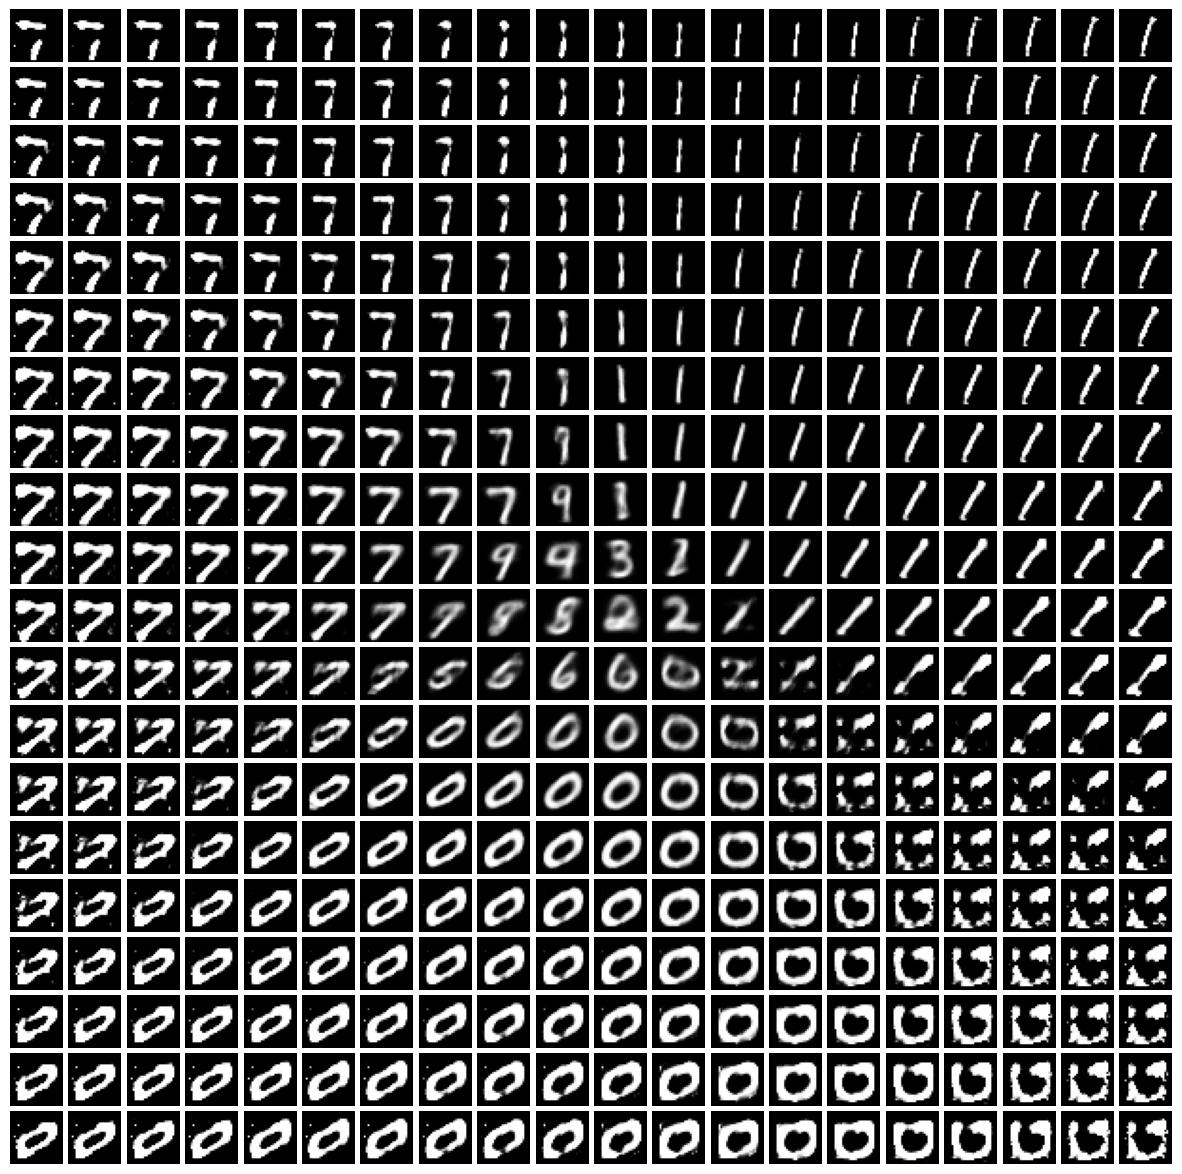

In [ ]:
print("2D Latent Space Grid:")
plot_latent_space_grid(trained_vae, n=20, x_range=(-10, 10), y_range=(-10, 10))

Q3. You have the following "new" example:

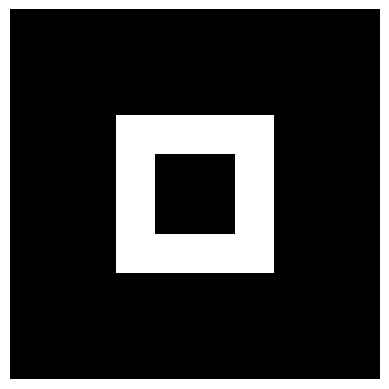

In [ ]:
img = torch.zeros(1, 28,28)
img[0,8:20,8:20]=1  # First image
img[0,11:17,11:17]=0  # First image
plt.imshow(img[0],cmap='gray')
plt.axis('off')
plt.show()


a. For the three autoencoders, plot the 2D scatterplot of the projection in latent space for examples in "val_loader" and new example (use a different color).

b. What are the results of reconstructing the three autoencoders for this new example?

c. How can you use an autoencoder to detect whether a new example resembles the objects in the training set?

**Answer:** When a new input image is similar to the training data, the encoder maps it to a representation that the decoder can easily understand. This results in a small reconstruction error. However, if the new input is very different from the training data—like having shapes or features not seen before—the model will have a hard time reconstructing it accurately, which leads to a large reconstruction error. So we can make decision by comparing the reconstruction error value of a new sample and our original sample and if they have significant differences we can conclude that our sample in notfrom traning set distribution

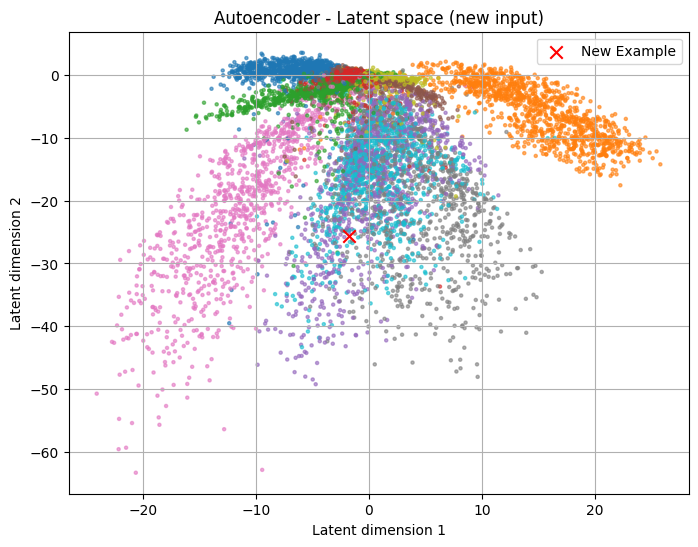

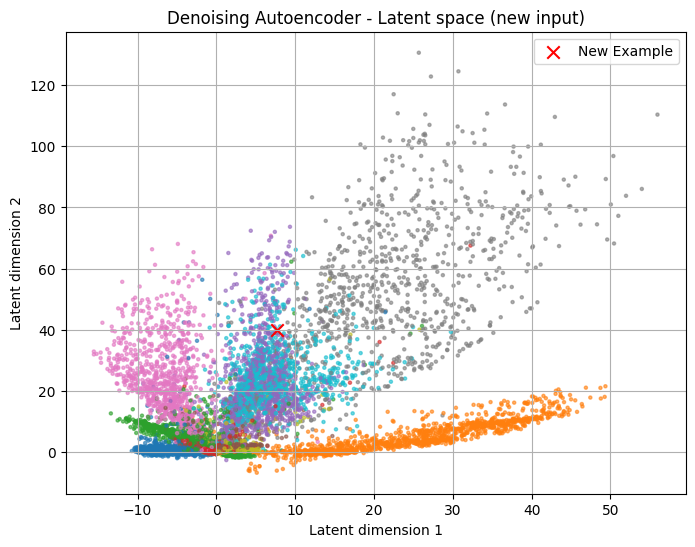

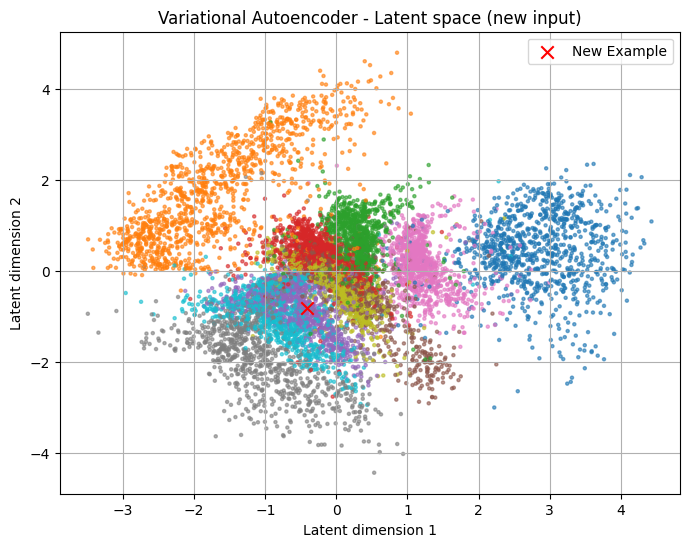

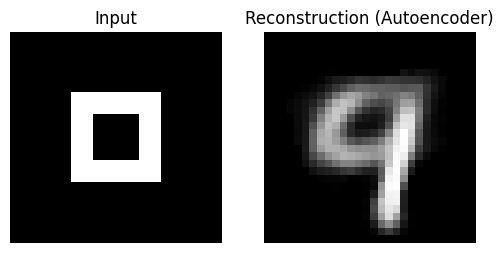

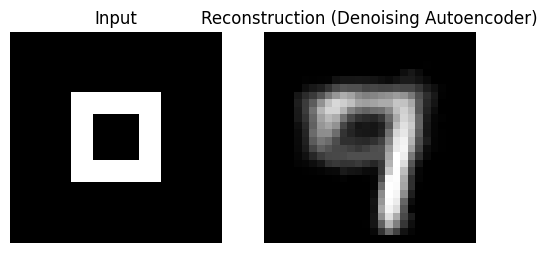

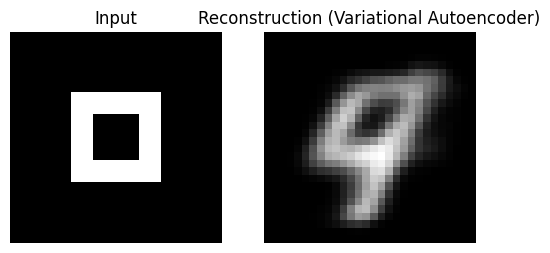

In [ ]:
# Project the new image in the latent space and plot it with the validation points
def plot_new_example_in_latent_space(model, valloader, new_img, title, isvae=False):
    model.eval()
    latents, labels = extract_latent_representations(model, valloader)

    new_img_flat = new_img.view(1, -1).to(device)
    with torch.no_grad():
        if isvae:
            mu, logvar = model.encode(new_img_flat)
            z = model.reparameterize(mu, logvar)
        else:
            z = model.encoder(new_img_flat)
        z = z.cpu().numpy()

    # Plot validation latent representations
    plt.figure(figsize=(8, 6))
    plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
    plt.scatter(z[:, 0], z[:, 1], c='red', s=80, marker='x', label='New Example')
    plt.title(title)
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot latent position for the new example in each model
plot_new_example_in_latent_space(trained_autoencoder, val_loader, img, "Autoencoder - Latent space (new input)")
plot_new_example_in_latent_space(trained_denoising_autoencoder, val_loader, img, "Denoising Autoencoder - Latent space (new input)")
plot_new_example_in_latent_space(trained_vae, val_loader, img, "Variational Autoencoder - Latent space (new input)", isvae=True)


# Reconstruct this new example with each model
def reconstruct_and_plot(model, img, title, isvae=False):
    model.eval()
    with torch.no_grad():
        img_flat = img.view(1, -1).to(device)
        if isvae:
            recon, _, _ = model(img_flat)
        else:
            recon = model(img_flat)
        recon = recon.cpu().view(28, 28).numpy()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Input")
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Reconstruction ({title})")
    plt.imshow(recon, cmap='gray')
    plt.axis('off')
    plt.show()

# Reconstruct the new image
reconstruct_and_plot(trained_autoencoder, img, "Autoencoder")
reconstruct_and_plot(trained_denoising_autoencoder, img, "Denoising Autoencoder")
reconstruct_and_plot(trained_vae, img, "Variational Autoencoder", isvae=True)

In [ ]:
# Detect if the image resembles the training data
def compute_reconstruction_error(model, img, isvae=False):
    model.eval()
    with torch.no_grad():
        img_flat = img.view(1, -1).to(device)
        if isvae:
            recon, _, _ = model(img_flat)
        else:
            recon = model(img_flat)
        error = torch.nn.functional.mse_loss(recon, img_flat).item()
    return error

for name, m, flag in [
    ("Autoencoder", trained_autoencoder, False),
    ("Denoising Autoencoder", trained_denoising_autoencoder, False),
    ("VAE", trained_vae, True)
]:
    err = compute_reconstruction_error(m, img, isvae=flag)
    print(f"{name} reconstruction error: {err:.6f}")

Autoencoder reconstruction error: 0.071482
Denoising Autoencoder reconstruction error: 0.071561
VAE reconstruction error: 0.081729


Q4. Write a function to generate 10 new examples for each autoencoder?  

In [ ]:
from sklearn.neighbors import KernelDensity

def generate_new_examples(model, latent_reps, n_samples=10, digitsize=28):
    # Fit a kernel density estimator (KDE) on the latent space of training data
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
    kde.fit(latent_reps)

    # Sample new latent points from the learned latent distribution
    z_sampled = kde.sample(n_samples)
    z_sampled = torch.tensor(z_sampled, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        # For Autoencoder and Denoising Autoencoder
        if hasattr(model, 'decoder'):
            generated = torch.sigmoid(model.decoder(z_sampled)).cpu()
        else:
            # For Variational Autoencoder
            generated = torch.sigmoid(model.decode(z_sampled)).cpu()

    # Plot
    generated = generated.view(n_samples, digitsize, digitsize)
    plt.figure(figsize=(12, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated[i].numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

Generated images - Autoencoder


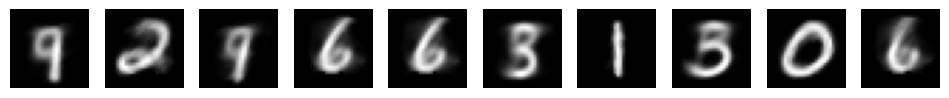

Generated images - Denoising Autoencoder


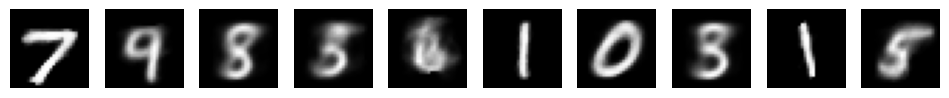

Generated images - Variational Autoencoder


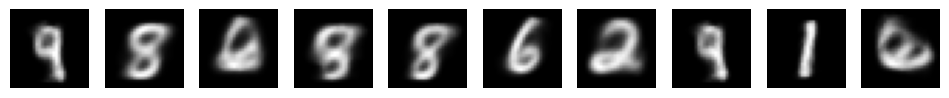

In [ ]:
# Extract latent representations from training data
latents_ae, _ = extract_latent_representations(trained_autoencoder, train_loader)
latents_dae, _ = extract_latent_representations(trained_denoising_autoencoder, train_loader)
latents_vae, _ = extract_latent_representations(trained_vae, train_loader)

print("Generated images - Autoencoder")
generate_new_examples(trained_autoencoder, latents_ae)

print("Generated images - Denoising Autoencoder")
generate_new_examples(trained_denoising_autoencoder, latents_dae)

print("Generated images - Variational Autoencoder")
generate_new_examples(trained_vae, latents_vae)


Q5. Write a function to generate 10 new examples of the class 0 for each autoencoder?

In [ ]:
def generate_class_0_examples(model, labeled_latents, labels, class_label=0, n_samples=10):
    # Filter the latent space for class 0
    class_latents = labeled_latents[labels == class_label]

    # Fit KDE on class-specific latent vectors
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
    kde.fit(class_latents)

    # Sample new latent vectors from the KDE
    z_samples = kde.sample(n_samples)
    z_samples = torch.tensor(z_samples, dtype=torch.float32).to(device)

    # Generate images from these latent vectors
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'decoder'):
            generated = torch.sigmoid(model.decoder(z_samples))
        else:
            generated = torch.sigmoid(model.decode(z_samples))

    # Plot
    plt.figure(figsize=(12, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated[i].view(28, 28).cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

Autoencoder - class 0 examples


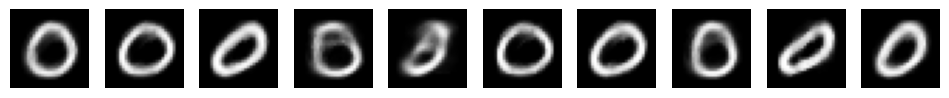

Denoising Autoencoder - class 0 examples


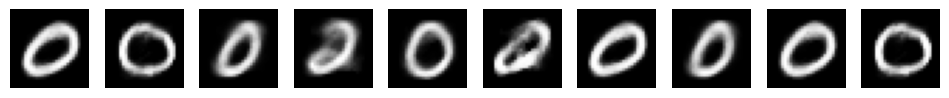

Variational Autoencoder - class 0 examples


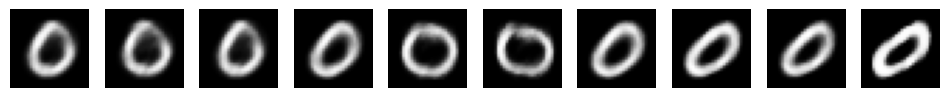

In [ ]:
# Extract latent representations and labels from train data
latents_ae, labels_train_ae = extract_latent_representations(trained_autoencoder, train_loader)
latents_dae, labels_train_dae = extract_latent_representations(trained_denoising_autoencoder, train_loader)
latents_vae, labels_train_vae = extract_latent_representations(trained_vae, train_loader)

print("Autoencoder - class 0 examples")
generate_class_0_examples(trained_autoencoder, latents_ae, labels_train_ae, class_label=0)

print("Denoising Autoencoder - class 0 examples")
generate_class_0_examples(trained_denoising_autoencoder, latents_dae, labels_train_dae, class_label=0)

print("Variational Autoencoder - class 0 examples")
generate_class_0_examples(trained_vae, latents_vae, labels_train_vae, class_label=0)

Q6. Autoencoders vs. PCA:

Compare the reconstructions and latent spaces of an autoencoder and PCA on the same dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Discuss the advantages and limitations of each method.

**Answer:** PCA offers a straightforward linear approach for dimensionality reduction and interpretability. In contrast, autoencoders provide a more powerful and flexible option, capable of compressing and reconstructing data in complex nonlinear forms.

When working with complicated data, like handwritten digits, autoencoders usually produce clearer images and better capture the underlying patterns. However, they are less easy to interpret and can be more challenging to train.

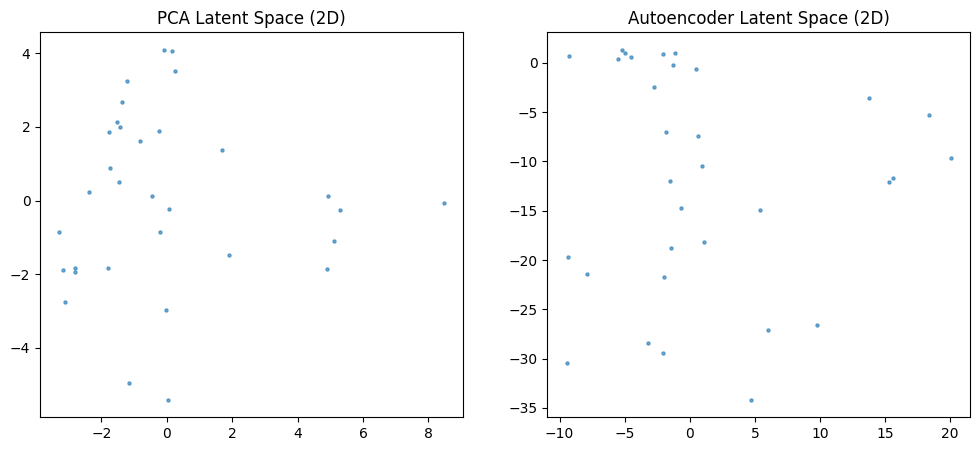

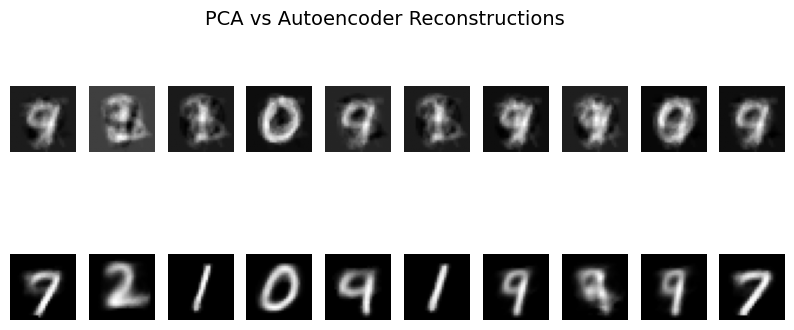

In [ ]:
from sklearn.decomposition import PCA


# Select subset of data for PCA comparison
data_subset = next(iter(val_loader))[0].view(-1, 28*28).numpy()
n_components = 2

# Fit PCA model
pca = PCA(n_components=n_components)
latent_pca = pca.fit_transform(data_subset)
reconstructed_pca = pca.inverse_transform(latent_pca)

# Autoencoder latent space and reconstruction
with torch.no_grad():
    ae_latent = trained_autoencoder.encoder(torch.FloatTensor(data_subset).to(device)).cpu().numpy()
    ae_reconstructed = trained_autoencoder(torch.FloatTensor(data_subset).to(device)).cpu().numpy()

# Plot latent spaces
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.6, s=5)
plt.title("PCA Latent Space (2D)")

plt.subplot(1, 2, 2)
plt.scatter(ae_latent[:, 0], ae_latent[:, 1], alpha=0.6, s=5)
plt.title("Autoencoder Latent Space (2D)")
plt.show()

# Plot a few reconstructed digits
n = 10
plt.figure(figsize=(10,4))
for i in range(n):
    # PCA reconstruction
    plt.subplot(2, n, i+1)
    plt.imshow(reconstructed_pca[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("PCA", fontsize=12)

    # Autoencoder reconstruction
    plt.subplot(2, n, i+n+1)
    plt.imshow(ae_reconstructed[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel("Autoencoder", fontsize=12)
plt.suptitle("PCA vs Autoencoder Reconstructions", fontsize=14)
plt.show()



The general formula for the KL divergence between two Gaussian distributions $N(\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1)$ and $N(\boldsymbol{\mu}_2,\boldsymbol{\Sigma}_2)$ is:

$   D_{\text{KL}}(q \parallel p) = \frac{1}{2} \left( \text{tr}(\boldsymbol{\Sigma}_1^{-1} \boldsymbol{\Sigma}_0) + (\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0)^T \boldsymbol{\Sigma}_1^{-1} (\boldsymbol{\mu}_1 - \boldsymbol{\mu}_0) - k + \ln \left( \frac{\det(\boldsymbol{\Sigma}_1)}{\det(\boldsymbol{\Sigma}_0)} \right) \right)$ where $\text{tr}$ is the trace and $\det$ the determinant.

**Q7. Compute the KL-divergence between two 1D Gaussian distributions step by step. Can you interpretate each one of the term? What happens if the two distribution have the same varianza?**

**Answer:**
The KL divergence between two 1D Gaussian distributions:

$q = N(\mu_1, \sigma_1^2)$
$p = N(\mu_2, \sigma_2^2)$

The formula:
$D_KL(q || p) = 0.5 * [  \dfrac{\sigma_1^2 }{\sigma_2^2} +  \dfrac{\mu_2 - \mu_1)^2}{\sigma_2^2} - 1 + \ln(\dfrac{\sigma_2^2}{\sigma_1^2}) ]$

Let's interpret each term:
1. $\dfrac{\sigma_1^2}{\sigma_2^2}$: measures how the variance of $q$ compares to $p$.
   - If this is $1$, both distributions have similar spread.
2. $\dfrac{(\mu_2 - \mu_1)^2}{\sigma_2^2}$: measures the squared difference in means relative to variance.
   - Large difference indicates a significant shift.
3. $-1$: a constant offset accounting for the divergence scale.
4. $\ln(\dfrac{\sigma_2^2}{\sigma_1^2})$: the log ratio of the variances, measuring how the spread differs logarithmically.

**If the two distributions have the same variance**:
- $\sigma_1^2 = \sigma_2^2$, then the terms simplify:
  - $\dfrac{\sigma_1^2}{\sigma_2^2} = 1$
  - $\ln(\dfrac{\sigma_2^2}{\sigma_1^2}) = 0$
- The KL divergence reduces to:
  $D_KL = 0.5 * [ 1 + \dfrac{(\mu_2 - \mu_1)^2}{\sigma_2^2} - 1 + 0 ] = 0.5 * \dfrac{(\mu_2 - \mu_1)^2}{\sigma_2^2}$

**What does this mean?**
- The divergence depends only on the squared difference of the means, scaled by the variance.
- If $\mu_1 = \mu_2$, the divergence is zero, indicating identical distributions.
#######################################################################



**Q8. Compute the KL-divergence for two Gaussian distribution with diagonal covariance matrix.**

**Answer:**
The KL divergence between two multivariate Gaussian distributions with diagonal covariance matrices:

$q = N(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1)$
$p = N(\boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2)$

where $\boldsymbol{\Sigma}_1 = \text{diag}(\sigma_{1,1}^2, \sigma_{1,2}^2, ..., \sigma_{1,d}^2)$ and $\boldsymbol{\Sigma}_2 = \text{diag}(\sigma_{2,1}^2, \sigma_{2,2}^2, ..., \sigma_{2,d}^2)$ are diagonal covariance matrices in $d$ dimensions.

**The formula:**
$ D_{KL}(q || p) = 0.5 \left[ \sum_{i=1}^{d} \dfrac{\sigma_{1,i}^2}{\sigma_{2,i}^2} + \sum_{i=1}^{d} \dfrac{(\mu_{2,i} - \mu_{1,i})^2}{\sigma_{2,i}^2} - d + \sum_{i=1}^{d} \ln\left(\dfrac{\sigma_{2,i}^2}{\sigma_{1,i}^2}\right) \right] $

This can be rewritten more compactly as:
$ D_{KL}(q || p) = 0.5 \left[ \text{tr}(\boldsymbol{\Sigma}_2^{-1} \boldsymbol{\Sigma}_1) + (\boldsymbol{\mu}_2 - \boldsymbol{\mu}_1)^T \boldsymbol{\Sigma}_2^{-1} (\boldsymbol{\mu}_2 - \boldsymbol{\mu}_1) - d + \ln\left(\dfrac{|\boldsymbol{\Sigma}_2|}{|\boldsymbol{\Sigma}_1|}\right) \right] $

**Interpretation of each term:**
1. $\sum_{i=1}^{d} \dfrac{\sigma_{1,i}^2}{\sigma_{2,i}^2}$: measures how the variance of $q$ compares to $p$ across all dimensions.
   - Sum of variance ratios for each dimension.
2. $\sum_{i=1}^{d} \dfrac{(\mu_{2,i} - \mu_{1,i})^2}{\sigma_{2,i}^2}$: measures the Mahalanobis distance between means.
   - Accounts for squared differences in means, normalized by the target variance in each dimension.
3. $-d$: constant offset for $d$ dimensions.
4. $\sum_{i=1}^{d} \ln\left(\dfrac{\sigma_{2,i}^2}{\sigma_{1,i}^2}\right)$: log-determinant ratio of covariance matrices.
   - Since covariances are diagonal: $\ln(|\boldsymbol{\Sigma}_2|/|\boldsymbol{\Sigma}_1|) = \sum_{i=1}^{d} \ln(\dfrac{\sigma_{2,i}^2}{\sigma_{1,i}^2})$


- With diagonal covariances, the KL divergence decomposes into a sum over independent dimensions.
- Each dimension contributes independently to the total divergence.
- This is essentially the sum of $d$ independent 1D KL divergences (as in Q7).


